In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.interpolate import interp1d

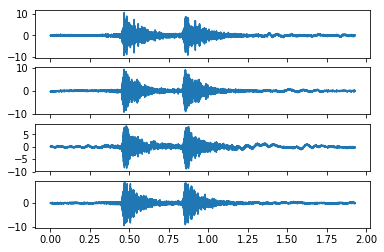

In [25]:
datafile = "onecheep.wav"

sample_rate, data = scipy.io.wavfile.read(datafile)
dt = 1/sample_rate
data = data.astype("float")
n_samples, n_channels = data.shape
fig, ax = plt.subplots(4, 1, sharex='all')
for i in range(n_channels):
    data[:, i] /= data[:, i].std()
    ax[i].plot(np.arange(n_samples)*dt, data[:, i])

In [119]:
c_sound = 343
class Microphone:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def arrival_time(self, x, y):
        return np.sqrt((x - self.x)**2 + (y - self.y)**2) / c_sound
      
mic_coords = np.array([[0, 0.375, 0, -0.375],
                      [-0.375, 0, 0.375, 0]])

# Rotation check, just to validate that code works (figure below rotates in opposite direction)
theta = 0.3
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


mics = [Microphone(m[0], m[1]) for m in np.dot(R, mic_coords).T]

def correlation_fn(mic1, mic2, f1, f2):
    c = np.correlate(f1, f2, 'full')
    
    # the spacing of the microphones and speed of sound determines the maximum possible 
    # time difference between signals. 0.9 factor is a safety factor 
    max_t_diff = np.sqrt((mic1.x - mic2.x)**2 + (mic1.y - mic2.y)**2) / (0.9*c_sound)
    t = np.arange(-n_samples+1, n_samples)*dt
    mask = (t > -max_t_diff) & (t < max_t_diff)
    
    # only create an interpolant on the relevant region
    fn = interp1d(t[mask], c[mask], kind='cubic')
    def corr(x, y):
        dt = mic1.arrival_time(x, y) - mic2.arrival_time(x, y)
        return fn(dt)
    return corr



In [120]:
pairs = (
(0, 1),
(0, 2),
(0, 3),
(1, 2), 
(1, 3), 
(2, 3))

c_funcs = []
for pair in pairs:
    i1, i2 = pair
    c_funcs.append(correlation_fn(mics[i1], mics[i2], data[:, i1], data[:, i2]))

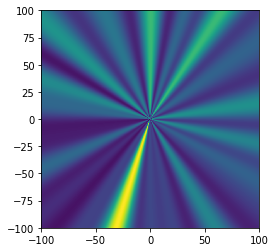

In [121]:
xmin, xmax = -100, 100
ymin, ymax = -100, 100
x = np.linspace(xmin, xmax, 1000)
y = np.linspace(ymin, ymax, 1000)
X, Y = np.meshgrid(x, y)

plt.imshow(c_funcs[0](X, Y) + c_funcs[1](X, Y) + c_funcs[2](X, Y) +
          c_funcs[3](X, Y) + c_funcs[4](X, Y) + c_funcs[5](X, Y), 
           extent=(xmin, xmax, ymin, ymax))
